In [1]:
# !sudo apt install swig

In [2]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data Import and Preprocessing

In [4]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (27160, 8)


In [5]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [6]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [7]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [8]:
##COVARIATE 6: Fundamental Indicators

DBITDA_ratio = pd.read_csv('datasets/fundemental indicators/DBITDA_ratio.csv')
PB_ratio = pd.read_csv('datasets/fundemental indicators/PB_ratio.csv')
PE_ratio = pd.read_csv('datasets/fundemental indicators/PE_ratio.csv')
PS_ratio = pd.read_csv('datasets/fundemental indicators/PS_ratio.csv')
quarterly_data = pd.read_csv('datasets/fundemental indicators/quaterlydata.csv')
ROE = pd.read_csv('datasets/fundemental indicators/ROE.csv')

df_portfolio_comb_3['date'] = pd.to_datetime(df_portfolio_comb_3['date'])
DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
PS_ratio['date'] = pd.to_datetime(PS_ratio['date'])
quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
ROE['date'] = pd.to_datetime(ROE['date'])

df_portfolio_comb_4 = df_portfolio_comb_3

df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, DBITDA_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PB_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PE_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PS_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, quarterly_data, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, ROE, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_4 = df_portfolio_comb_4.sort_values(by=['tic', 'date'])

# Forward fill missing data
df_portfolio_comb_4['TTM Revenue(Billion)'] = df_portfolio_comb_4['TTM Revenue(Billion)'].ffill()
df_portfolio_comb_4['TTM EBITDA(Billion)'] = df_portfolio_comb_4['TTM EBITDA(Billion)'].ffill()
df_portfolio_comb_4['EBITDA Margin'] = df_portfolio_comb_4['EBITDA Margin'].ffill()
df_portfolio_comb_4['Price to Book Ratio'] = df_portfolio_comb_4['Price to Book Ratio'].ffill()
df_portfolio_comb_4['PE Ratio'] = df_portfolio_comb_4['PE Ratio'].ffill()
df_portfolio_comb_4['Price to Sales Ratio'] = df_portfolio_comb_4['Price to Sales Ratio'].ffill()
df_portfolio_comb_4['Assets'] = df_portfolio_comb_4['Assets'].ffill()
df_portfolio_comb_4['NetIncomeLoss'] = df_portfolio_comb_4['NetIncomeLoss'].ffill()
df_portfolio_comb_4['Return on Equity(%)'] = df_portfolio_comb_4['Return on Equity(%)'].ffill()

/var/folders/2g/0vz2g1lj5q30v5yz2rqq26m40000gn/T/ipykernel_21880/1570567354.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
/var/folders/2g/0vz2g1lj5q30v5yz2rqq26m40000gn/T/ipykernel_21880/1570567354.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
/var/folders/2g/0vz2g1lj5q30v5yz2rqq26m40000gn/T/ipykernel_21880/1570567354.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
/var/folders/2g/0vz2g1lj5q30v5yz2rqq26m40000gn/T/ipykernel_21880/1570567354.py:14: UserWarning: Pa

In [9]:
df_portfolio_final = df_portfolio_comb_4

In [10]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

date                              datetime64[ns]
open                                     float64
high                                     float64
low                                      float64
close                                    float64
volume                                     int64
tic                                       object
day                                        int32
Open_VIX                                 float64
High_VIX                                 float64
Low_VIX                                  float64
Close_VIX                                float64
Adj Close_VIX                            float64
Open_SPY                                 float64
High_SPY                                 float64
Low_SPY                                  float64
Close_SPY                                float64
Adj Close_SPY                            float64
Volume_SPY                               float64
Fear Greed                               float64
ratingScore         

In [11]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [12]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [13]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,Price to Book Ratio,Net EPS,PE Ratio,TTM Sales per Share,Price to Sales Ratio,Assets,NetIncomeLoss,TTM Net Income (Billions),Shareholder's Equity (Billion),Return on Equity(%)
0,2014-01-02,0.083921,0.083767,0.084581,0.073559,0.220253,AAPL,0.75,0.173177,0.170703,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10,2014-01-03,0.083495,0.083267,0.082805,0.071944,0.368333,AAPL,1.00,0.170033,0.166374,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
20,2014-01-06,0.081168,0.082229,0.081759,0.072336,0.387238,AAPL,0.00,0.162172,0.163800,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
30,2014-01-07,0.082206,0.082103,0.082421,0.071819,0.297703,AAPL,0.25,0.149716,0.155376,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
40,2014-01-08,0.081374,0.082043,0.082539,0.072273,0.242632,AAPL,0.50,0.157697,0.154908,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27119,2024-10-10,0.983313,0.979104,0.979417,0.982213,0.121309,XOM,0.75,0.000000,0.000000,...,0.229913,0.0,0.377179,0.0,0.264706,0.963788,0.659341,0.0,0.0,0.807644
27129,2024-10-11,0.982834,0.981716,0.984623,0.985962,0.098234,XOM,1.00,0.000000,0.000000,...,0.229913,0.0,0.377179,0.0,0.264706,0.963788,0.659341,0.0,0.0,0.807644
27139,2024-10-14,0.983952,0.983537,0.982060,0.989710,0.116155,XOM,0.00,0.000000,0.000000,...,0.229913,0.0,0.377179,0.0,0.264706,0.963788,0.659341,0.0,0.0,0.807644
27149,2024-10-15,0.964631,0.965252,0.959314,0.959958,0.186777,XOM,0.25,0.000000,0.000000,...,0.229913,0.0,0.377179,0.0,0.264706,0.963788,0.659341,0.0,0.0,0.807644


In [14]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics',
                                  'TTM Revenue(Billion)',
                                  'TTM EBITDA(Billion)',
                                  'EBITDA Margin',
                                  'Price to Book Ratio',
                                  'PE Ratio',
                                  'Price to Sales Ratio',
                                  'Assets',
                                  'NetIncomeLoss',
                                  'Return on Equity(%)']]

In [15]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

# Feature Selection and DRL Model Parameters

In [16]:
FEATURE_NAMES = ["close",
                  #"high", 
                  #"low",
                  #'High_VIX',
                  #'Low_VIX',
                  #'Close_VIX',
                  'High_SPY',
                  #'Low_SPY',
                  'Close_SPY',
                  #'Volume_SPY',
                  'Fear Greed', 
                  'ratingScore',
                  #'ratingDetailsDCFScore',
                  #'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                  #'exports', 
                  #'imports',
                  'pound_dollar_exchange_rate', 
                  'unemployment',
                  #'ics',
                  #'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  'EBITDA Margin',
                  'Price to Book Ratio',
                  'PE Ratio',
                  #'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                  'Return on Equity(%)']

TIME_WINDOW = 50
COMISSION_FEE = 0.0025
K_SIZE = 5
CONV_MID = 5
CONV_FINAL= 5

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features":CONV_MID,
    "conv_final_features":CONV_FINAL}

EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

# DRL Model Training (Jan 2014- Dec 2022)

In [17]:
DRLAgent.train_model(EIIE_model, episodes=10)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE(test).pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 278982.71875
Final accumulative portfolio value: 2.7898271875
Maximum DrawDown: -0.31605581971454766
Sharpe ratio: 0.7267373671044336


 10%|█         | 1/10 [00:27<04:09, 27.68s/it]

Initial portfolio value:100000
Final portfolio value: 358634.84375
Final accumulative portfolio value: 3.5863484375
Maximum DrawDown: -0.34431169404677364
Sharpe ratio: 0.8596210345133378


 20%|██        | 2/10 [00:55<03:39, 27.50s/it]

Initial portfolio value:100000
Final portfolio value: 498797.3125
Final accumulative portfolio value: 4.987973125
Maximum DrawDown: -0.3750704174633336
Sharpe ratio: 0.9897646205821142


 30%|███       | 3/10 [01:22<03:12, 27.46s/it]

Initial portfolio value:100000
Final portfolio value: 876093.25
Final accumulative portfolio value: 8.7609325
Maximum DrawDown: -0.3742440558892538
Sharpe ratio: 1.0337963913737191


 40%|████      | 4/10 [01:54<02:55, 29.19s/it]

Initial portfolio value:100000
Final portfolio value: 1888970.5
Final accumulative portfolio value: 18.889705
Maximum DrawDown: -0.36855605597434293
Sharpe ratio: 1.3638240243025739


 50%|█████     | 5/10 [02:18<02:16, 27.22s/it]

Initial portfolio value:100000
Final portfolio value: 2358049.75
Final accumulative portfolio value: 23.5804975
Maximum DrawDown: -0.38039722371126894
Sharpe ratio: 1.41892080361154


 60%|██████    | 6/10 [02:42<01:44, 26.13s/it]

Initial portfolio value:100000
Final portfolio value: 2444694.0
Final accumulative portfolio value: 24.44694
Maximum DrawDown: -0.3851248794852289
Sharpe ratio: 1.406744521723403


 70%|███████   | 7/10 [03:10<01:20, 26.82s/it]

Initial portfolio value:100000
Final portfolio value: 2204122.25
Final accumulative portfolio value: 22.0412225
Maximum DrawDown: -0.3851570065998654
Sharpe ratio: 1.376448892713156


 80%|████████  | 8/10 [03:36<00:53, 26.69s/it]

Initial portfolio value:100000
Final portfolio value: 1331224.125
Final accumulative portfolio value: 13.31224125
Maximum DrawDown: -0.3940780051699374
Sharpe ratio: 1.1558494400118673


 90%|█████████ | 9/10 [04:06<00:27, 27.57s/it]

Initial portfolio value:100000
Final portfolio value: 1822696.875
Final accumulative portfolio value: 18.22696875
Maximum DrawDown: -0.3851585863004635
Sharpe ratio: 1.2926841690028295


100%|██████████| 10/10 [04:34<00:00, 27.44s/it]


# DRL Model Evaluation (Jan 2023-Oct 2024)

In [18]:
import os
import shutil

environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)


EIIE_results = {
    "train": {},
    "test": {} }

# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE(test).pt"))

/var/folders/2g/0vz2g1lj5q30v5yz2rqq26m40000gn/T/ipykernel_21880/2611291164.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("poli

<All keys matched successfully>

In [19]:
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
          'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)

In [20]:
environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(environment)

src_folder = "results/rl"
dst_folder = "results/test"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_test, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]
EIIE_results["test"]["actions"] = environment_test._actions_memory
portfolio_test_value, drawdown_test, sharpe_test, cumulative_test = calculate_metrics(environment_test)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "test": {"value": [], "actions": []} }


PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]


# test
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = environment_test._asset_memory["final"]


Initial portfolio value:100000
Final portfolio value: 1720569.0
Final accumulative portfolio value: 17.20569
Maximum DrawDown: -0.385159088436711
Sharpe ratio: 1.2821398274459832
Initial portfolio value:100000
Final portfolio value: 142277.578125
Final accumulative portfolio value: 1.42277578125
Maximum DrawDown: -0.18555818297445037
Sharpe ratio: 1.3194674652238219
Initial portfolio value:100000
Final portfolio value: 339680.78125
Final accumulative portfolio value: 3.3968078125
Maximum DrawDown: -0.35322268924350886
Sharpe ratio: 0.8385026769134679
Initial portfolio value:100000
Final portfolio value: 137105.265625
Final accumulative portfolio value: 1.37105265625
Maximum DrawDown: -0.09963569254853266
Sharpe ratio: 1.9145094330592534


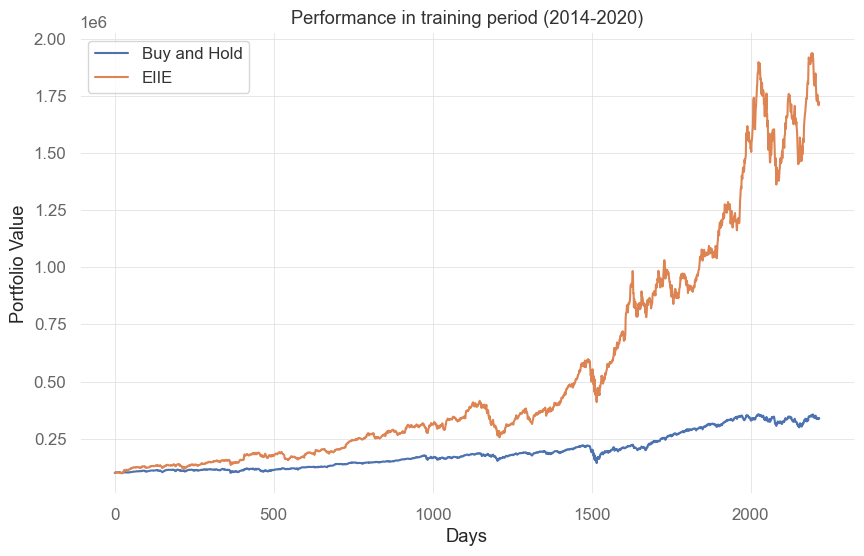

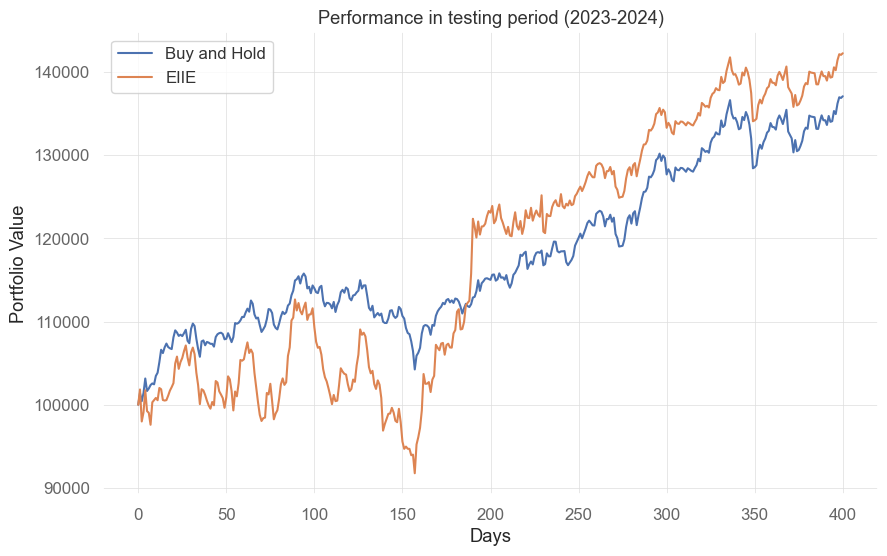

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period (2014-2020)")
plt.legend()

plt.show()

plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period (2023-2024)")
plt.legend()

plt.show()

# Portfolio Allocation by Trained DRL Model

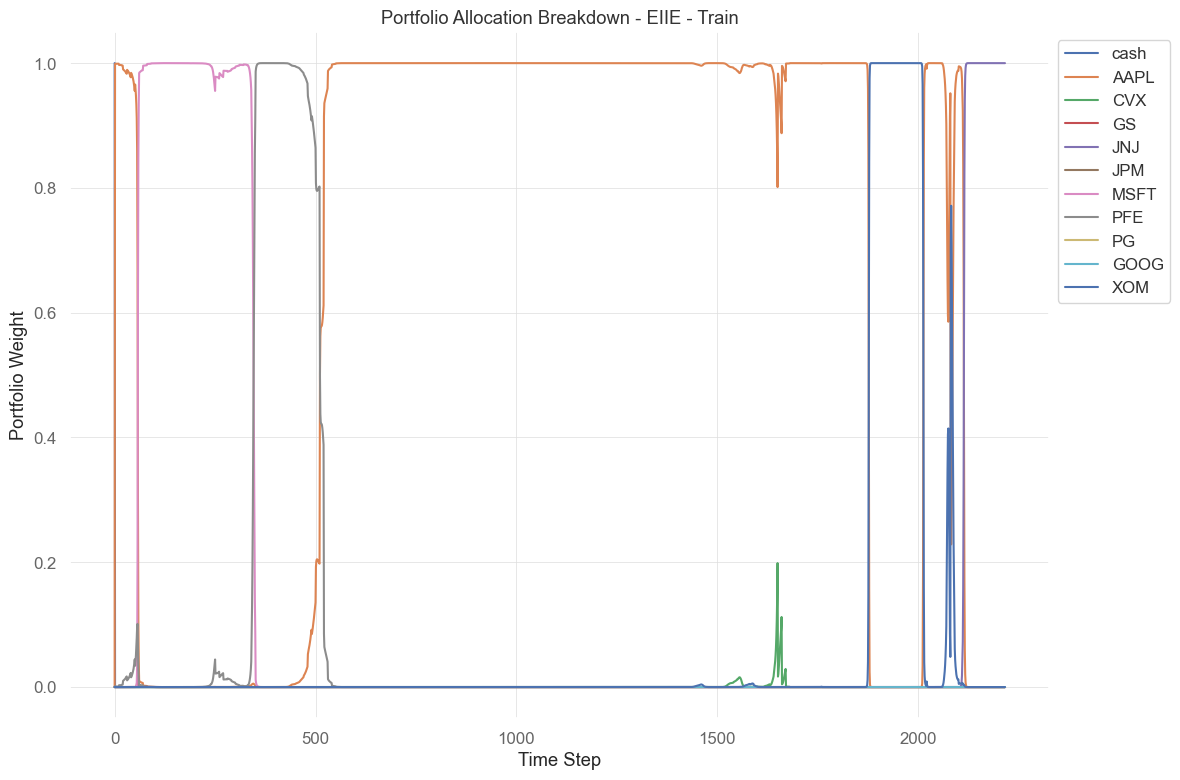

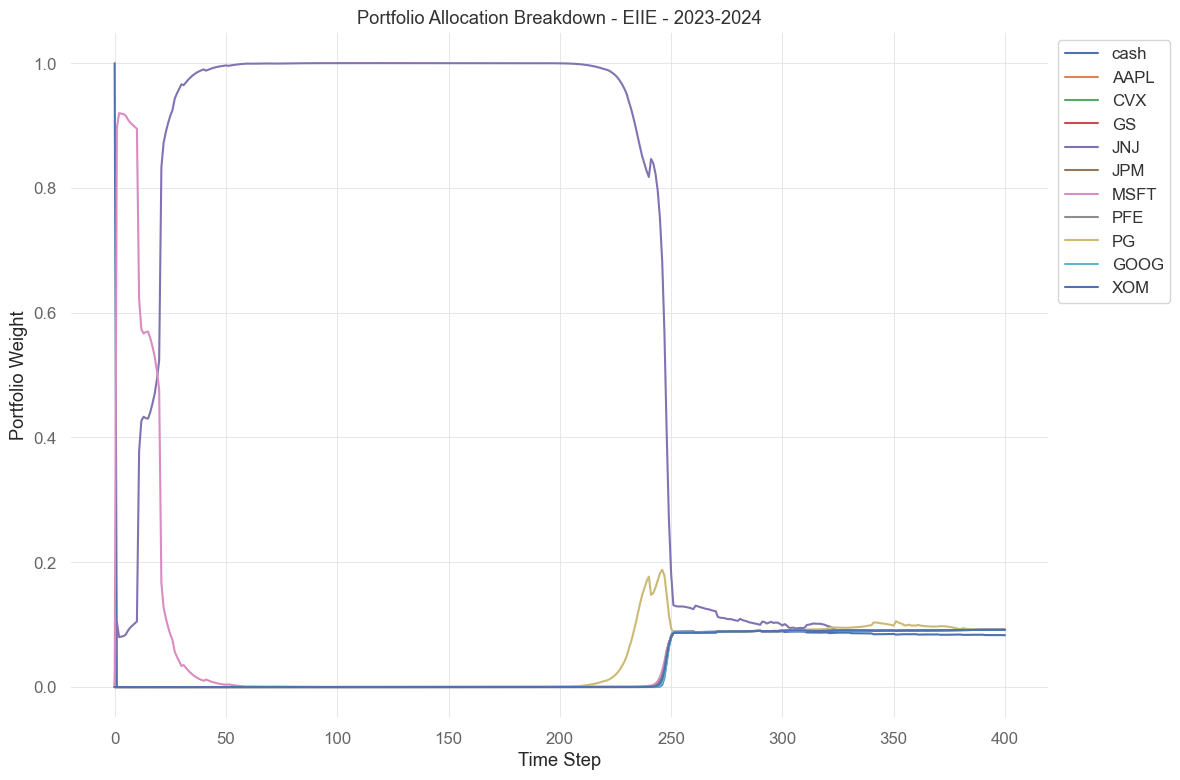

In [22]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for test
plot_action_memory(EIIE_results["test"]["actions"], TEST_SET, "EIIE - 2023-2024")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Plot action memory as stacked bar chart as monthly averages/ daily

In [24]:
# not sure if the dates are wrong for monthly

def plot_action_memory_stacked(actions, tickers, label, start_date, frequency='daily'):
    
    # Convert actions to a DataFrame
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    
    # create a range of dates 
    actions_df.index = pd.date_range(start=start_date, periods=len(actions), freq='D')

    # if freq is monthly, calculate monthly average
    if frequency == 'monthly':
        actions_df = actions_df.resample('ME').mean() 

    ax = actions_df.plot(kind="bar", stacked=True, figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}", legend=False)

    # set x-axis labels based on the frequency; daily (range of days), monthly (year-month)
    if frequency == 'daily':
        ax.set_xticks(range(0, len(actions_df), 50))  # Adjust the step size as needed
        ax.set_xticklabels([f"Day {i}" for i in range(0, len(actions_df), 50)], rotation=90)
    elif frequency == 'monthly':
        ax.set_xticklabels(actions_df.index.strftime('%Y-%m'), rotation=90) 

    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return None


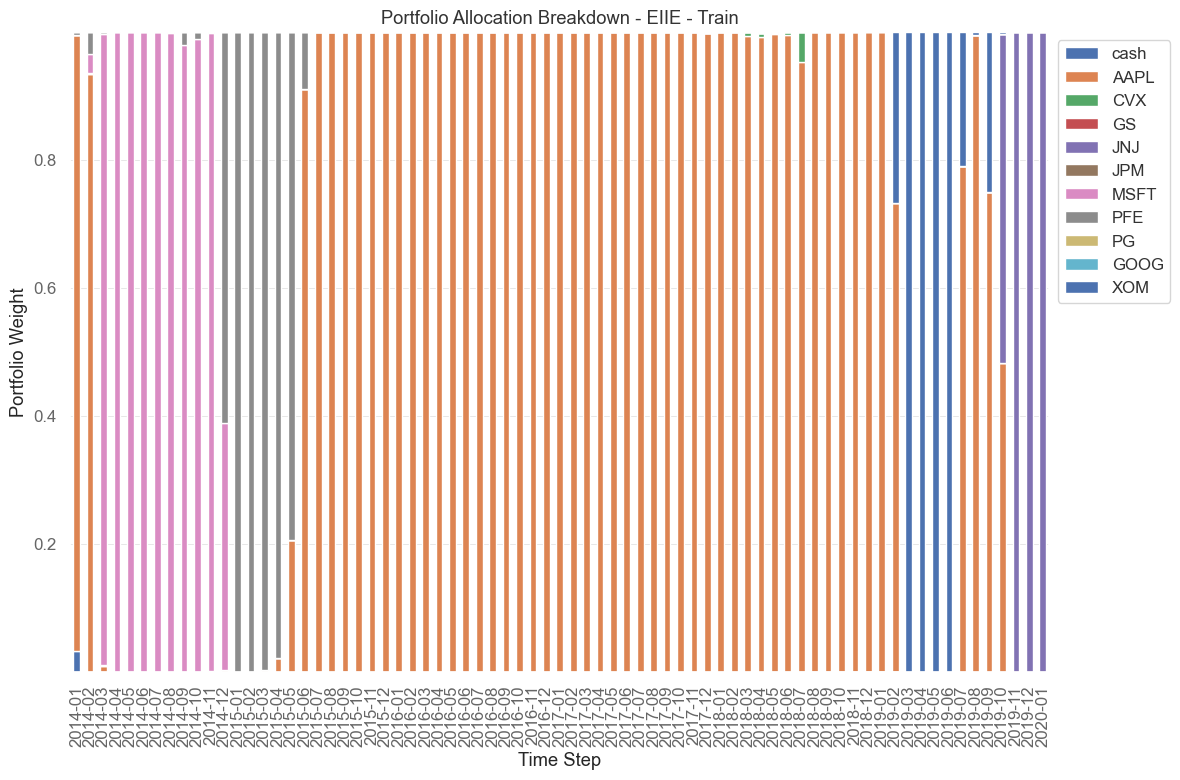

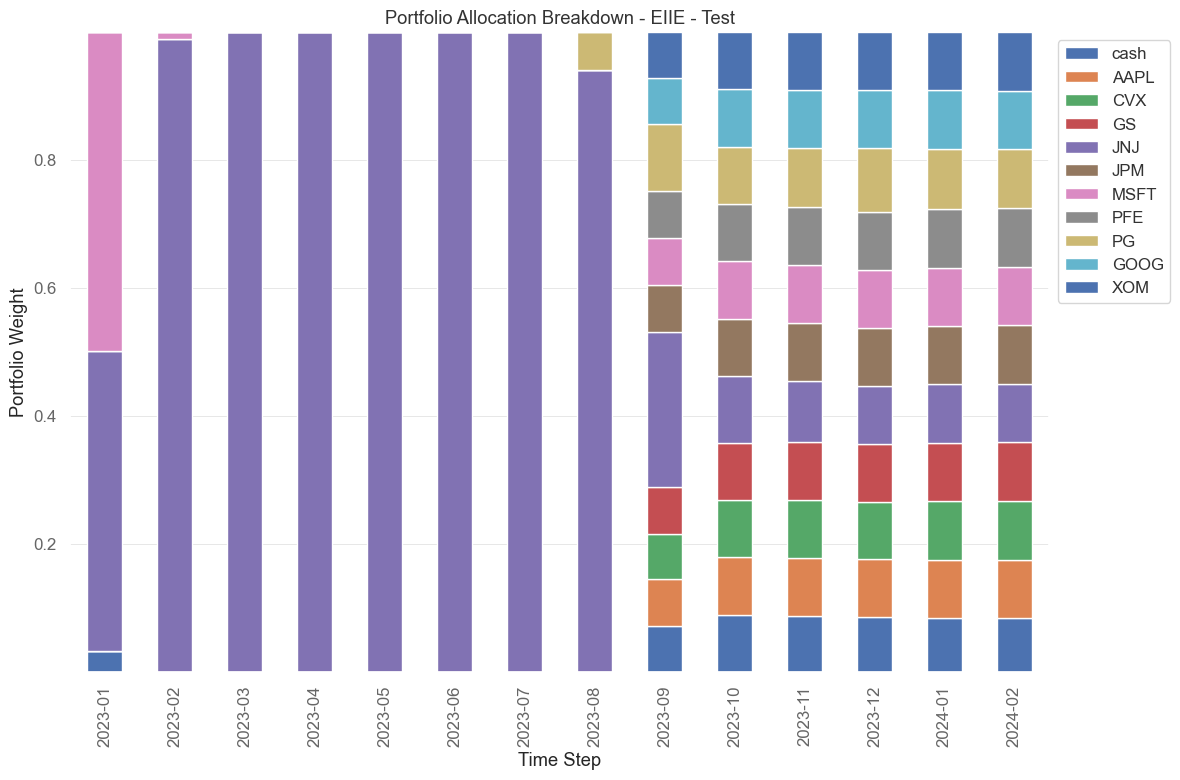

In [25]:
plot_action_memory_stacked(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train", start_date=START_DATE, frequency='monthly')
plot_action_memory_stacked(EIIE_results["test"]["actions"], TEST_SET, "EIIE - Test", start_date="2023-01-01", frequency='monthly')

### Plot action memory as stacked area chart

In [26]:
def plot_action_memory_stacked_area(actions, tickers, label, filename):
    
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    x = range(len(actions_df))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.stackplot(x, actions_df.T, labels=["Cash"] + tickers)
    
    plt.title(f"Portfolio Allocation Breakdown - {label}", weight="bold", fontsize=18)
    plt.ylabel("Proportion of portfolio taken up by stock", weight="bold", fontsize=16, labelpad=15)
    plt.xlabel("Days", weight="bold", fontsize=16, labelpad=15)
    
    ax.tick_params(axis='both', labelsize=15) 
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)

    plt.show()
    
    return None


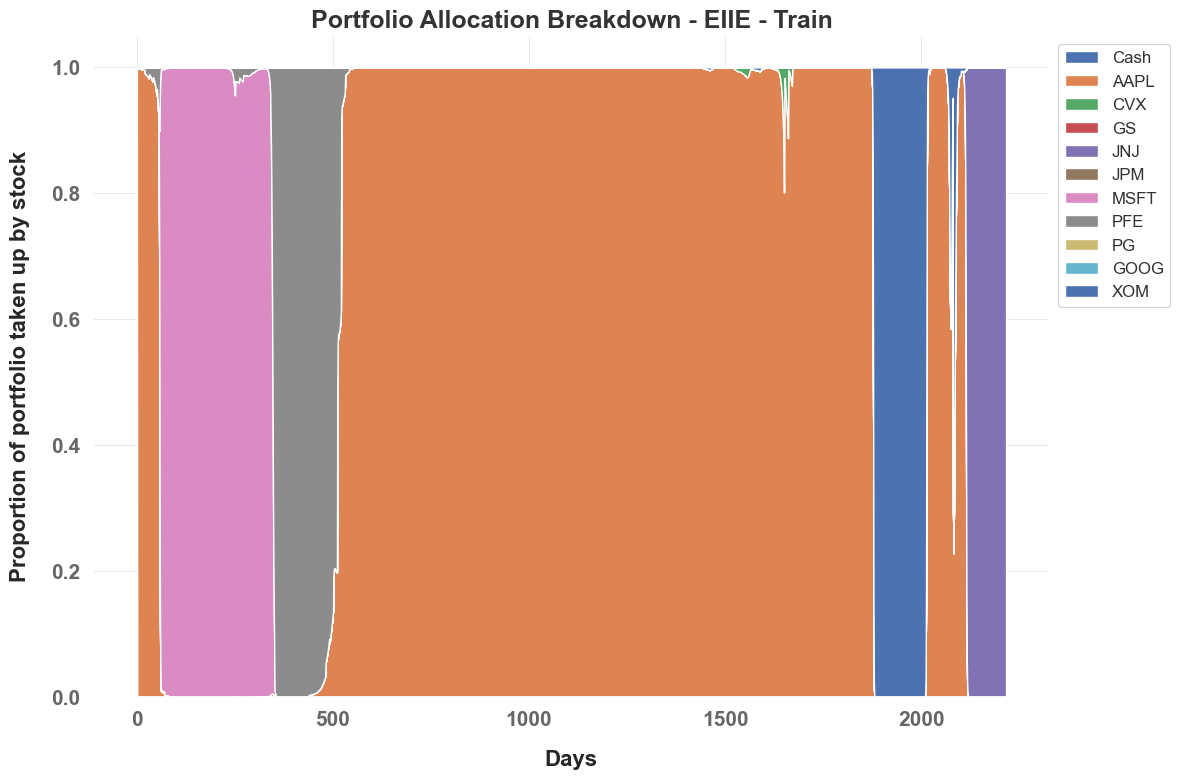

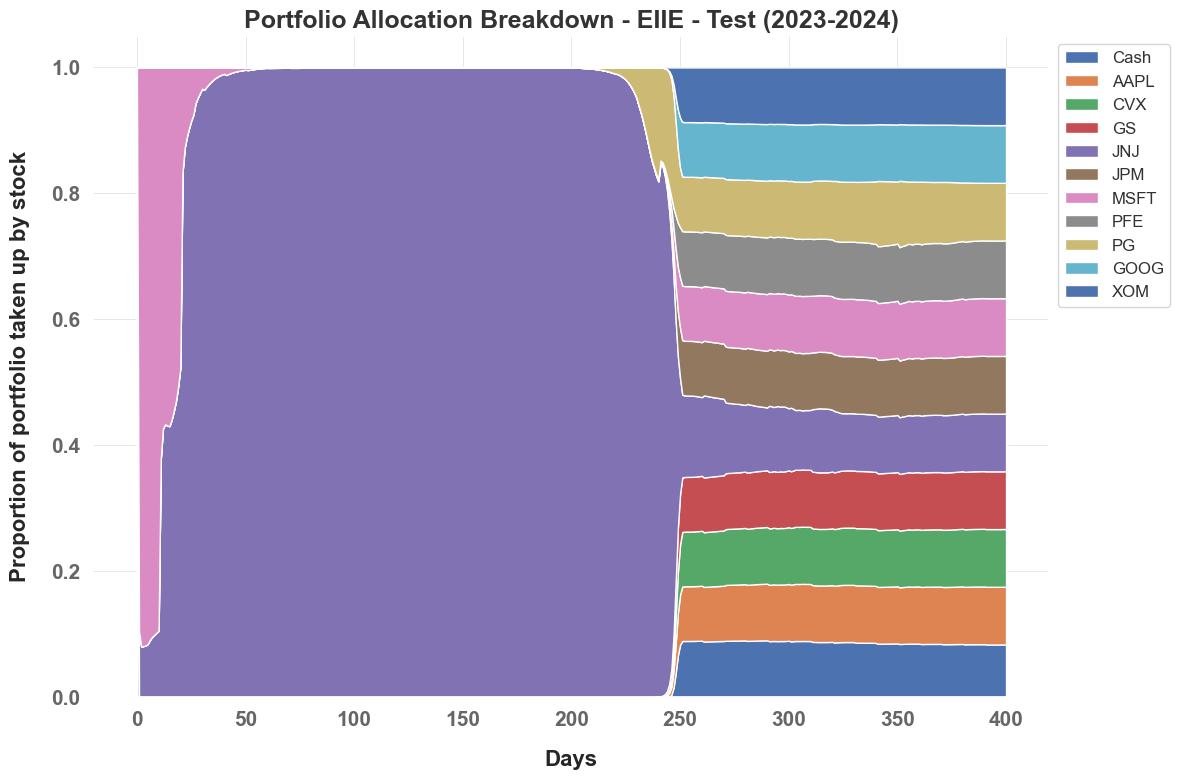

In [33]:
plot_action_memory_stacked_area(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train", "EIIE - Train.png")
plot_action_memory_stacked_area(EIIE_results["test"]["actions"], TEST_SET, "EIIE - Test (2023-2024)", "EIIE - 2023-2024.png")

### Plot action memory as heatmap

In [34]:
def plot_action_memory_heatmap(actions, tickers, label):    
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df_T = actions_df.T
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(actions_df_T, cmap="coolwarm", cbar_kws={'label': 'Portfolio Weight'})
    
    plt.title(f"Portfolio Allocation Heatmap - {label}")
    plt.xlabel("Time Step (Day)")
    plt.ylabel("Assets")
    
    
    plt.tight_layout()
    plt.show()
    return None

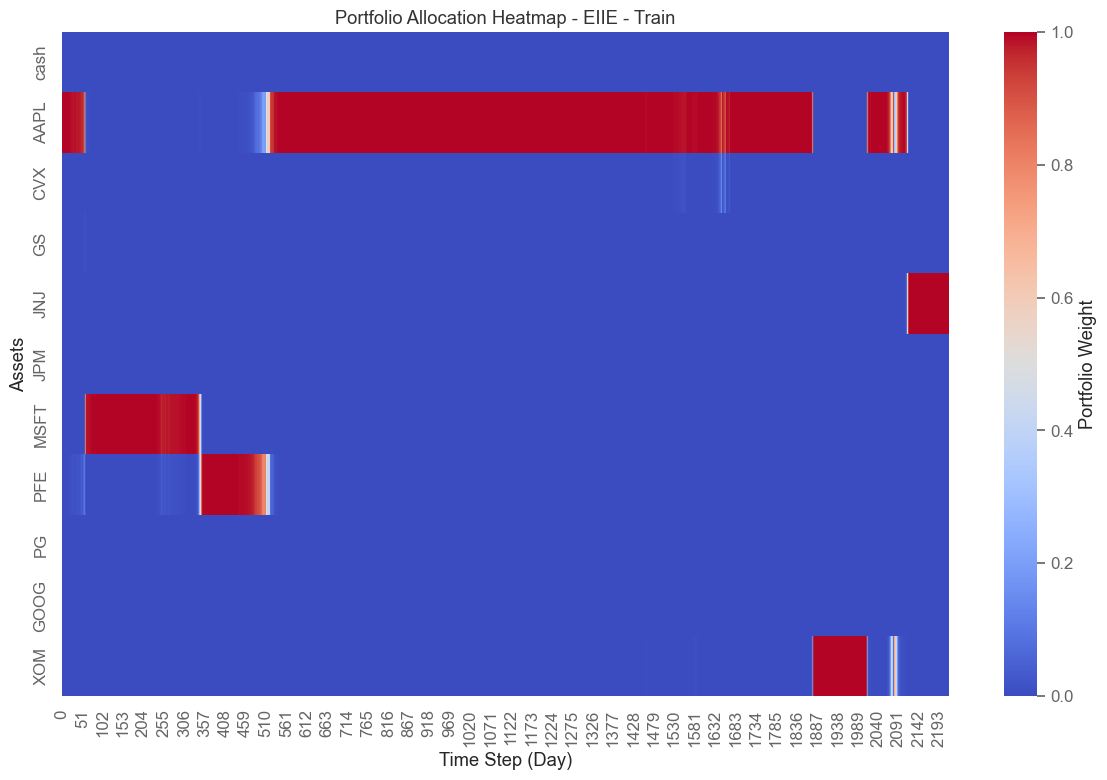

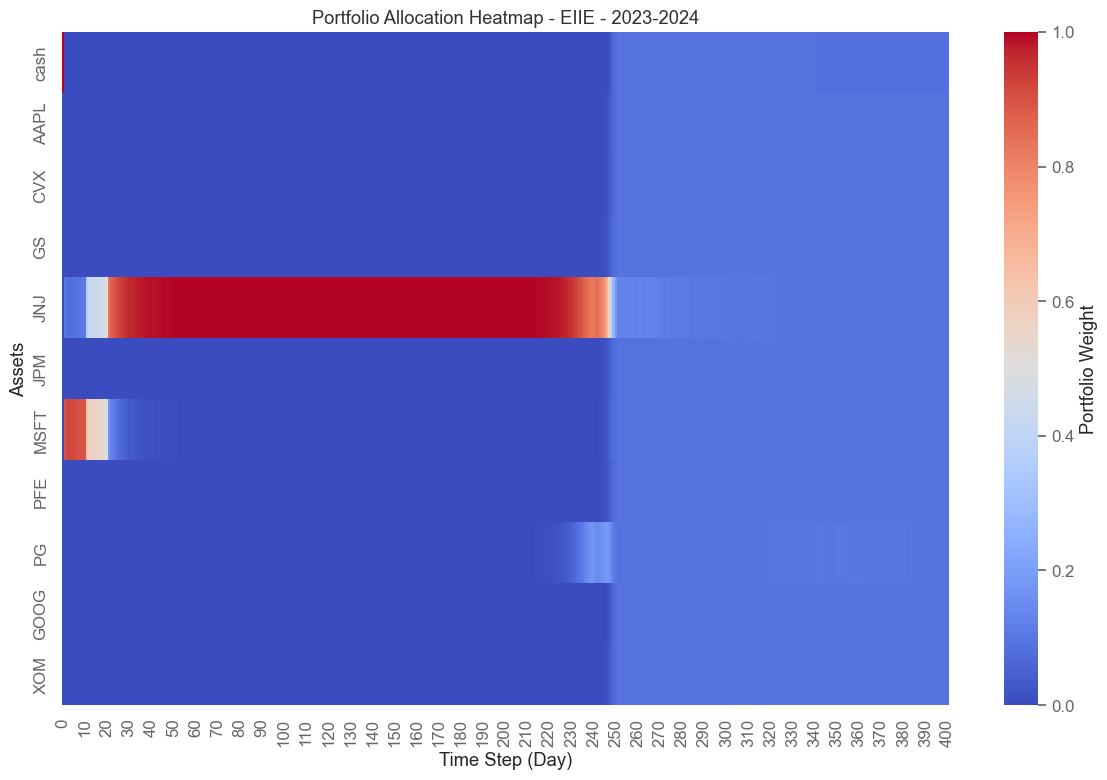

In [35]:
plot_action_memory_heatmap(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")
plot_action_memory_heatmap(EIIE_results["test"]["actions"], TEST_SET, "EIIE - 2023-2024")

In [30]:
temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "test_portfolio_value": portfolio_test_value, "test_drawdown": drawdown_test, "test_sharpe": sharpe_test, "test_cumulative": cumulative_test}]
)
results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df

/var/folders/2g/0vz2g1lj5q30v5yz2rqq26m40000gn/T/ipykernel_21880/415509565.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,train_drawdown,train_sharpe,train_cumulative,test_portfolio_value,test_drawdown,test_sharpe,test_cumulative
0,50,5,5,5,1720569.0,-0.385159,1.28272,17.20569,142277.578125,-0.185558,1.32278,1.422776


In [31]:
results_df.to_csv('filename.csv', index=False)

In [32]:
END_DATE

'2024-12-31'